# Make tfRecord files

## Import modules

In [1]:
from data_utils import *

import os 
from glob import glob

import multiprocessing as mp

import tensorflow as tf 
from sklearn import preprocessing

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Declare paths

In [2]:
data_path = 'UrbanSound8K'
audio_path = data_path + "/" + 'audio'
meta_path = data_path + "/" +'metadata/' +'UrbanSound8K.csv'

## Make dir for tfRecords

In [ ]:
if not os.path.isdir(data_path+'/tfRecords'):
    os.mkdir(data_path+'/tfRecords')

## Load metadata

In [ ]:
meta_data = pd.read_csv(meta_path)
meta_data['duration'] = meta_data['end']-meta_data['start']
print(meta_data.head())

## Load audio  file paths into dictionary

In [ ]:
audio_folders = glob(audio_path+"/f*")
audio_files = {}
for folder in sorted(audio_folders):
    audio_files[folder.split("/")[-1]] = glob(folder+"/*.wav")
n_samples = sum([len(audio_files[k]) for k in audio_files.keys()])
print("Number of samples: {}".format(n_samples))

for k in audio_files.keys():
    print("N-samples for {}: {}".format(k,len(audio_files[k])) )

## Make list of pd.DataFrame for path and class

In [ ]:
all_data = []

for k in audio_files.keys():
    labels, classIds = [], []
    for sample_path in audio_files[k]:
        sample_name = sample_path.split("/")[-1].split(".")[0]+".wav"
        row = meta_data[meta_data['slice_file_name'] == sample_name]
        sample_label =  row['class'].values[0]
        class_id = row['classID'].values[0]
        labels.append(sample_label)
        classIds.append(class_id)
    new_df = pd.DataFrame(list(zip(audio_files[k],labels,classIds)))
    all_data.append(new_df)  

In [ ]:
print(all_data[0].head())

In [ ]:
print(all_data[1].head())

## Make folds into tfRecords

### Make MelSpect records

In [ ]:
if not os.path.isdir(data_path+'/tfRecords/MelSpect'):
    os.mkdir(data_path+'/tfRecords/MelSpect')

In [ ]:
def writeMelSpect(df):
    paths, labels = df.iloc[:,0].tolist(),df.iloc[:,2].tolist()  
    name = paths[0].split("/")[2]
    record_name = data_path+'/tfRecords/MelSpect/' + name + '.tfrec'
      
    with tf.io.TFRecordWriter(record_name) as writer:
        for i, audio_path in enumerate(paths):
            # Add sample to tfRecord file 
            audio_data, _ = librosa.load(audio_path, sr=22050)
            spect = LogMelSpectMesh(audio_data)
            example = createTF_Example(spect, labels[i])
            writer.write(example.SerializeToString())

In [ ]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    pool.map(writeMelSpect, all_data)

### Make MFCC records

In [ ]:
if not os.path.isdir(data_path+'/tfRecords/MFCC'):
    os.mkdir(data_path+'/tfRecords/MFCC')

In [ ]:
def writeMFCC(df):
    paths, labels = df.iloc[:,0].tolist(),df.iloc[:,2].tolist()  
    name = paths[0].split("/")[2]
    record_name = data_path+'/tfRecords/MFCC/' + name + '.tfrec'
      
    with tf.io.TFRecordWriter(record_name) as writer:
        for i, audio_path in enumerate(paths):
            # Add sample to tfRecord file 
            audio_data, _ = librosa.load(audio_path, sr=22050)
            spect = MFCCMesh(audio_data)
            example = createTF_Example(spect, labels[i])
            writer.write(example.SerializeToString())

In [ ]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    pool.map(writeMFCC, all_data)

### Make Chroma records

In [ ]:
if not os.path.isdir(data_path+'/tfRecords/Chroma'):
    os.mkdir(data_path+'/tfRecords/Chroma')

In [ ]:
def writeChroma(df):
    paths, labels = df.iloc[:,0].tolist(),df.iloc[:,2].tolist()  
    name = paths[0].split("/")[2]
    record_name = data_path+'/tfRecords/Chroma/' + name + '.tfrec'
      
    with tf.io.TFRecordWriter(record_name) as writer:
        for i, audio_path in enumerate(paths):
            # Add sample to tfRecord file 
            audio_data, _ = librosa.load(audio_path, sr=22050)
            spect = ChromaMesh(audio_data)
            example = createTF_Example(spect, labels[i])
            writer.write(example.SerializeToString())

In [ ]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    pool.map(writeChroma, all_data)

## Read tfRecord

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

In [4]:
sample_dataset = get_dataset(data_path+'/tfRecords/MelSpect/fold2.tfrec',AUTO)
sample_dataset = sample_dataset.batch(1)

tf.Tensor([[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


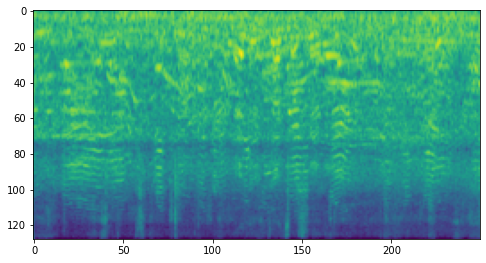

In [5]:
for sample in sample_dataset.take(1):
    image, target = sample
    print(target)
    plt.figure(figsize=(8, 8))
    plt.imshow(image.numpy()[0,:,:,0])
    plt.show()

In [6]:
sample_dataset = get_dataset(data_path+'/tfRecords/MFCC/fold2.tfrec',AUTO)
sample_dataset = sample_dataset.batch(1)

tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


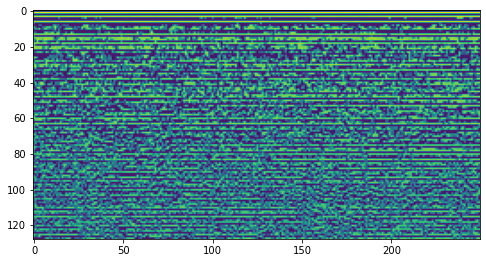

In [7]:
for sample in sample_dataset.take(1):
    image, target = sample
    print(target)
    plt.figure(figsize=(8, 8))
    plt.imshow(image.numpy()[0,:,:,0])
    plt.show()

In [8]:
sample_dataset = get_dataset(data_path+'/tfRecords/Chroma/fold2.tfrec',AUTO)
sample_dataset = sample_dataset.batch(1)

tf.Tensor([[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


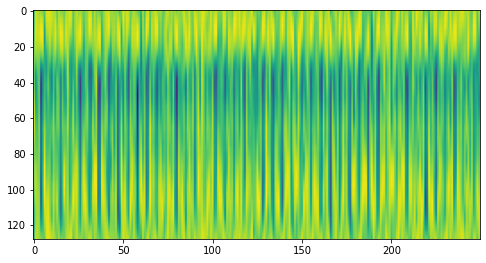

In [9]:
for sample in sample_dataset.take(1):
    image, target = sample
    print(target)
    plt.figure(figsize=(8, 8))
    plt.imshow(image.numpy()[0,:,:,0])
    plt.show()